# Notebook configuration

In [72]:
run_numbers   = 4583,
save_plots    = False
outputfolder  = "plots/{}/{}".format("Cs", run_numbers[0])
corr_filename = "run{}_corrections.h5".format(4446)
inputfilename = "/Users/Gonzalo/github/NEXTdata/Cs137/dst_{}.root.h5"

Zrange        =     0, 600
XYrange       =  -198, 198
Rrange        =     0, max(XYrange)
Prange        =  -3.2, 3.2  
Erange_raw    =     0, 250e3
Erange_zcorr  =     0, 250e3
Erange_xycorr =   7e3, 250e3
XRrange_raw    =    0,  15e3
XRrange_zcorr  =  4e3,  12e3
XRrange_xycorr =  6e3,  12e3
Qrange        =     0, 300e2
QErange       =     0, Qrange[1]/Erange_xycorr[1]
Frange        =   0.8, 1.5
Urange        =  1e-2, 1e-1

NSirange      =     0, 30

Zrange_DV     =   545, 555
Zrange_LT     =    50, 520
Zrange_XY     =     0, 520
nX, nY, nR    =    50,  50, 50
x0, y0, r0    =    40, -40, 15 # for lifetime scan

# Kr analysis

In [73]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  . dst_io        as dstio
import invisible_cities.io  .kdst_io        as kdstio
import invisible_cities.reco.corrections    as corrf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import covariance
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import measurement_string
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import poisson_sigma
from invisible_cities.icaro.hst_functions import plot_writer

pi   = np.pi
save = plot_writer(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Tue Aug 15 18:17:13 2017


#### General plotting options

In [74]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Read data

In [75]:
full = dstio.load_dsts([inputfilename.format(run) for run in run_numbers], "DST", "Events")
full = full[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full))
full.head()

145579


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.502133e+09,0,1,175.0,16.573950,87.241216,894475.0,11.904375,21740.093750,...,1004237.5,165,109.7625,109.7625,47.603783,77.530381,90.978460,1.020145,31.323017,36.885737
1,2,1.502133e+09,0,1,200.0,32.077038,170.348656,699725.0,47.575000,10744.871094,...,1031512.5,104,331.7875,331.7875,-112.945256,11.553912,113.534681,3.039651,21.261901,19.700598
2,3,1.502133e+09,0,1,175.0,26.533182,136.164050,836625.0,24.792500,14396.042969,...,1010537.5,172,173.9125,173.9125,-87.326647,12.513034,88.218588,2.999271,30.138869,28.408456
3,4,1.502133e+09,0,1,175.0,27.880442,145.312320,882200.0,41.883750,18183.529297,...,1012212.5,167,130.0125,130.0125,-132.275213,-0.487388,132.276111,-3.137908,25.411981,24.213981
4,5,1.502133e+09,0,1,150.0,18.638519,89.657207,982125.0,16.535688,20698.324219,...,1012412.5,96,30.2875,30.2875,4.912402,-59.092401,59.296235,-1.487856,21.662886,22.386061


In [52]:
XYcorr = dstf.load_xy_corrections(corr_filename)

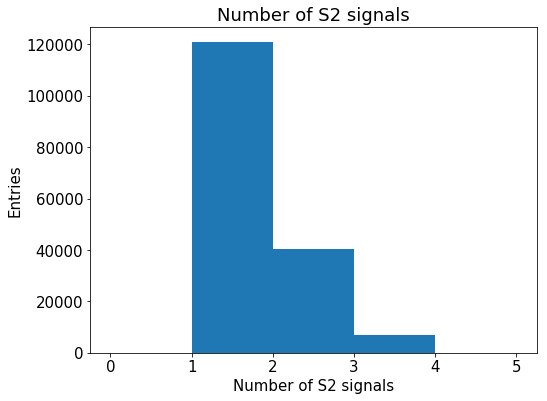

In [53]:
hist(full.nS2, 5, (0, 5))
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

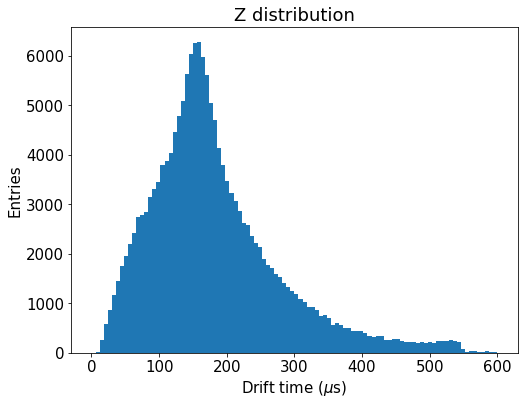

In [54]:
hist(full.Z, 100, Zrange)
labels("Drift time ($\mu$s)", "Entries", "Z distribution")
save("Z")

T1/2 = 635225495.25 +- 451268505962989.19 y


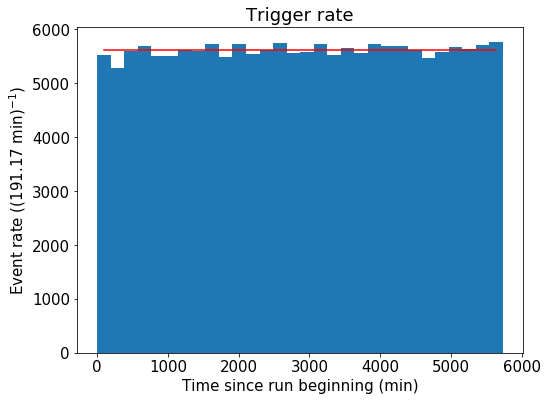

In [55]:
T       = full.time.values / 60
T      -= np.min(T)
 
y, x, _  = hist(T, 30, (np.min(T), np.max(T)))
bin_size = np.diff(x)[0]

sel = y > 20
f = fitf.fit(fitf.expo, x[sel], y[sel], (6e3, -1e4), sigma=poisson_sigma(y[sel]))

plt.plot(x, f.fn(x), fitOpt)
labels("Time since run beginning (min)",
       "Event rate (({:.2f} min)$^{{-1}}$)".format(bin_size),
       "Trigger rate")
save("EventRate")

scale = np.log(2)*bin_size/60/24/365.25
print("T1/2 = {:.2f} +- {:.2f} y".format(-f.values[1]*scale, f.errors[1]*scale))

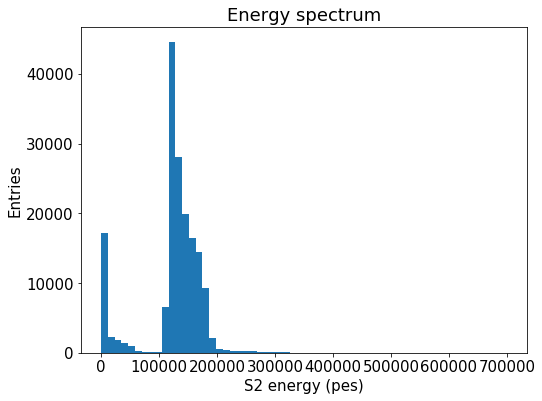

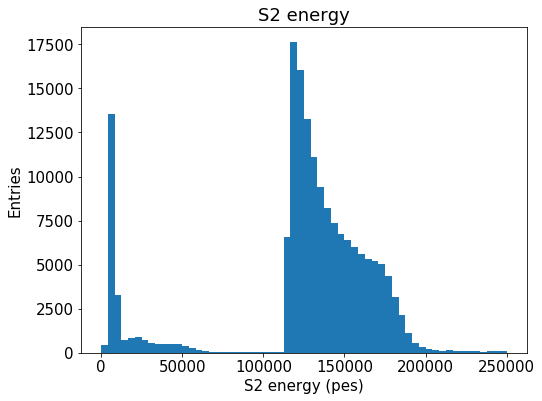

In [56]:
hist(full.S2e, 60, (0, 700e3))
labels("S2 energy (pes)", "Entries", "Energy spectrum")
save("Raw_energy_wide")

hist(full.S2e, 60, Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("Raw_energy")

# S2 energy

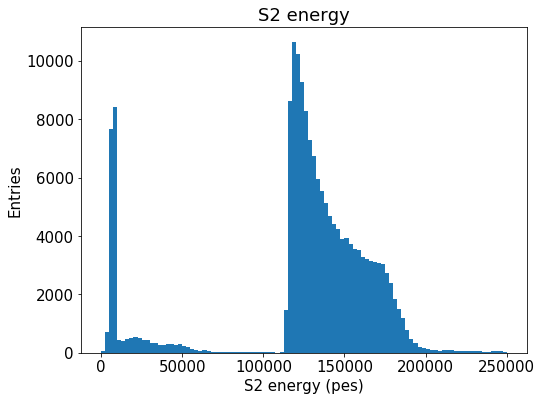

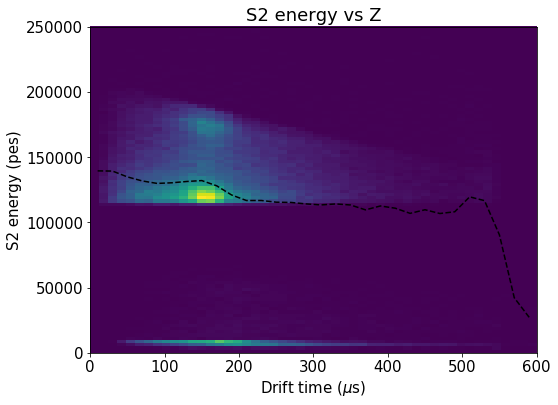

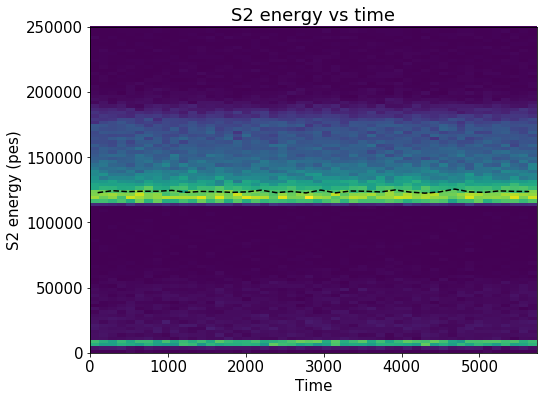

In [57]:
hist(full.S2e, 100, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("S2energy")

hist2d(full.Z, full.S2e, (50, 100), range=(Zrange, Erange_raw))
x, y, _ = fitf.profileX(full.Z, full.S2e, 30, xrange=Zrange, yrange=Erange_raw)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 energy vs Z")
save("S2energyvsZ")

hist2d(T, full.S2e, (50, 100), range=((0,np.max(T)), Erange_raw))
x, y, _ = fitf.profileX(T, full.S2e, 30, xrange=(0,np.max(T)), yrange=Erange_raw)
plt.plot(x, y, profOpt)

labels("Time", "S2 energy (pes)", "S2 energy vs time")
save("S2energyvsZ")

# Lifetime calculation

In [58]:
fid = full
fid = fid[fid.R < 100] # Fiducialize in order to reduce geometrical effects
print("Ratio:", len(fid)/len(full))
fid.head()

Ratio: 0.39876688406571864


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.502442e+09,0,1,200.0,27.480299,146.183712,682100.0,31.208500,13969.372070,...,1020212.5,105,338.1125,338.1125,-39.679370,-2.723466,39.772725,-3.073063,25.253176,20.669254
3,5,1.502442e+09,0,1,175.0,17.383211,91.076324,946650.0,30.705625,15983.760742,...,1011137.5,202,64.4875,64.4875,-24.159935,25.748606,35.308542,2.324374,80.808991,79.805332
5,8,1.502442e+09,0,1,175.0,25.294958,129.954687,946675.0,22.181500,21639.013672,...,1017537.5,280,70.8625,70.8625,62.898238,18.793434,65.645879,0.290347,39.852977,36.444394
6,9,1.502442e+09,0,1,150.0,23.629436,111.538568,952875.0,23.800000,18776.080078,...,1004187.5,119,51.3125,51.3125,-2.237772,-20.884513,21.004059,-1.677539,25.497892,22.022313
7,10,1.502442e+09,0,1,200.0,30.216658,167.310342,773550.0,15.966000,19461.201172,...,1006937.5,134,233.3875,233.3875,-48.825741,2.540772,48.891804,3.089602,30.659870,30.887676


# S2 energy fiducialized

Energy at z=0 = 9145.0 +- 23.4
Lifetime      = 1463.1 +- 24.9
Chi2          = 0.80          


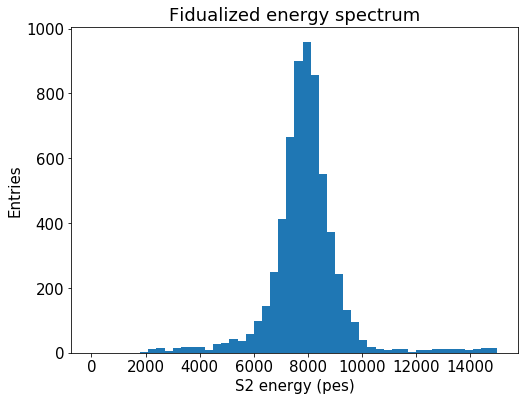

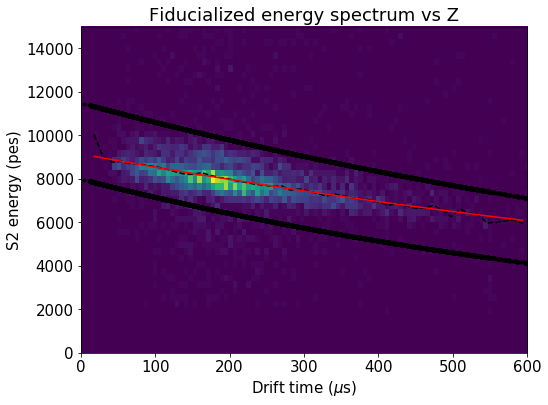

In [59]:
hist(fid.S2e, 50, range=XRrange_raw)
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
save("Raw_energy_fiducial")

low_cut   =  8000 * np.exp(-0.0011*fid.Z.values)
high_cut  = 11500 * np.exp(-0.0008*fid.Z.values)
sel       = coref.in_range(fid.S2e.values, low_cut, high_cut) # remove low and high E background

hist2d(fid.Z, fid.S2e, (100, 50), range=(Zrange, XRrange_raw))
x, y, u_y = fitf.profileX(fid.Z[sel], fid.S2e[sel], 50, xrange=Zrange, yrange=XRrange_raw)

plt.plot(x, y, profOpt)
plt.plot(fid.Z.values,  low_cut, "k.")
plt.plot(fid.Z.values, high_cut, "k.")

seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

plt.plot(x, f.fn(x), fitOpt)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("Raw_energy_vsZ_fiducial")

Zcorr = corrf.LifetimeCorrection(-f.values[1], f.errors[1])
Zcorr = corrf.LifetimeCorrection(1400, 1)

In [60]:
E_xyzcorr = full.S2e.values * Zcorr(full.Z.values).value * XYcorr(full.X.values, full.Y.values).value

# Full spectrum (energy scale from XR)

Peak energy: 641.3 +- 2.0 keV


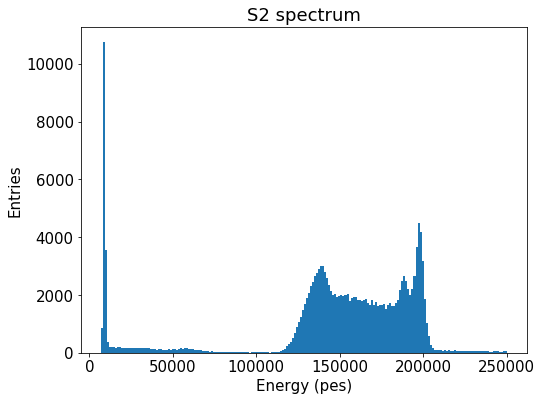

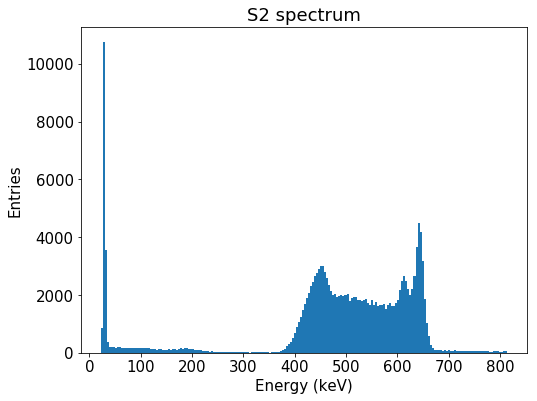

In [61]:
hist(E_xyzcorr, 200, Erange_xycorr)
labels("Energy (pes)", "Entries", "S2 spectrum")

#scale  = 511/161e3
scale  = 29.6/9100
#scale  = 41.5/12400
Erange = [i*scale for i in Erange_xycorr]
y, x, _ = hist(E_xyzcorr*scale, 200, Erange)

_ = x > 100
print("Peak energy: {} keV".format(measurement_string(x[_][np.argmax(y[_])], np.diff(x)[0]*0.5)))
labels("Energy (keV)", "Entries", "S2 spectrum")

# XR peak

In [62]:
full_range =     0, 165e3
XR_range   =   4e3,  12e3
PP_range   = 130e3, 165e3

XR_fit_range =  8200, 12000
PP_fit_range = 136e3, 160e3

XR1_fit_seed =  8500
XR2_fit_seed = 10000
PP1_fit_seed = 155e3
PP2_fit_seed = 144e3

XR1_energy_keV = 29.7
XR2_energy_keV = 33.8

PP1_energy_keV = 511
PP2_energy_keV = PP1_energy_keV - XR1_energy_keV

Qbb_energy_keV = 2458

Resolution at 29.7 keV: 7.95 +- 0.12
Resolution at 2458 keV: 0.874 +- 0.013
Chi2                  : 1.3117710057


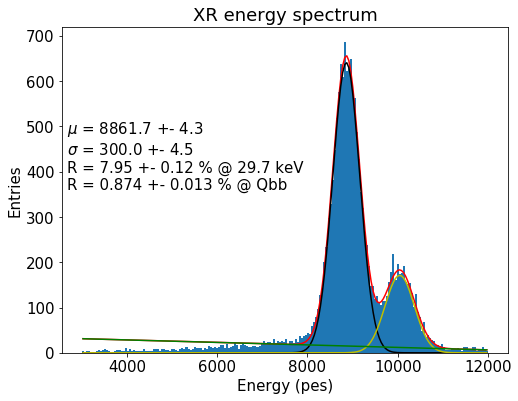

In [63]:
y, x, _ = \
hist(E_xyzcorr, 200, (3e3, 12e3))

#fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
#seed = 1e5, 8700, 100, 1e5, 10000, 100, 10, 1e-1
#fitr = 7000, 11000

#f = fitf.fit(fun, x, y, seed, fit_range=fitr, sigma=poisson_sigma(y))

#assert not np.any(np.isclose(f.values, seed))

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = np.sum(y)
seed = ndat    , XR1_fit_seed    , XR1_fit_seed*0.03, ndat    , XR2_fit_seed    , XR2_fit_seed*0.03,  np.mean(y)/10, -1e-2
low  = ndat/1e2, XR1_fit_seed*0.9, XR1_fit_seed*0.01, ndat/100, XR2_fit_seed*0.9, XR2_fit_seed*0.01, -np.mean(y)   , -1e+1
upp  = ndat*1e2, XR1_fit_seed*1.1, XR1_fit_seed*0.06, ndat*100, XR2_fit_seed*1.1, XR2_fit_seed*0.06,  np.mean(y)   , +1e+1

f = fitf.fit(fun, x, y, seed, fit_range=XR_fit_range, sigma=poisson_sigma(y), bounds=(low, upp))
assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

print("Resolution at 29.7 keV:", measurement_string(*resolution(f.values, f.errors, 29.7)[0]))
print("Resolution at 2458 keV:", measurement_string(*resolution(f.values, f.errors, 29.7)[1]))
print("Chi2                  :", f.chi2)

plt.plot(x, f.fn(x), "r-")
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")

plt.text(plt.xlim()[0] * 1.05, plt.ylim()[1]/2,
         gausstext(f.values, f.errors, 29.7))

plt.ylim(0)
labels("Energy (pes)", "Entries", "XR energy spectrum")

# Photopeak

In [64]:
PP_range     = 150e3, 220e3
PP_fit_range = 150e3, 205e3

PP1_fit_seed = 195e3
PP2_fit_seed = 187e3

PP1_energy_keV = 662
PP2_energy_keV = PP1_energy_keV - XR1_energy_keV

Qbb_energy_keV = 2458

AssertionError: [False False False False  True False False False False]

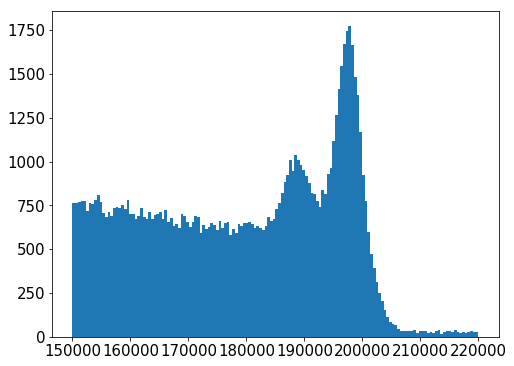

In [66]:
y, x, _ = \
hist(E_xyzcorr, 150, (150e3, 220e3))

#fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
#seed = 1e5, 197e3, 1e3, 1e5, 187e3, 1e3, 1e2, -40, 1e-4
#fitr = 150e3, 205e3

#f = fitf.fit(fun, x, y, seed, fit_range=fitr, sigma=poisson_sigma(y))

#assert not np.any(np.isclose(f.values, seed))

fun  = lambda x, *args: fitf.gauss  (x, *args[ :3]) + \
                        fitf.gauss  (x, *args[3:6]) + \
                        fitf.polynom(x, *args[6: ])

ndat = np.sum(y)
seed = ndat    , PP1_fit_seed     , PP1_fit_seed*0.010, ndat    , PP2_fit_seed     , PP2_fit_seed*0.010, -1e3, 1e-2, -1e-7
low  = ndat/1e2, PP1_fit_seed*0.99, PP1_fit_seed*0.003, ndat/1e2, PP2_fit_seed*0.99, PP2_fit_seed*0.003, -1e5,    0, -1e-1
upp  = ndat*1e4, PP1_fit_seed*1.01, PP1_fit_seed*0.020, ndat*1e4, PP2_fit_seed*1.01, PP2_fit_seed*0.030,    0, 1e+3,     0

f = fitf.fit(fun, x, y, seed, fit_range=PP_fit_range, sigma=poisson_sigma(y), bounds=(low, upp))

assert not np.any(np.isclose(f.values, seed)), np.isclose(f.values, seed)
assert not np.any(np.isclose(f.values, low) ), np.isclose(f.values, low )
assert not np.any(np.isclose(f.values, upp) ), np.isclose(f.values, upp )

print("Resolution at 662  keV:", measurement_string(*resolution(f.values, f.errors, 662)[0]))
print("Resolution at 2458 keV:", measurement_string(*resolution(f.values, f.errors, 662)[1]))
print("Chi2                  :", f.chi2)

plt.plot(x, f.fn(x), "r-")
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")

plt.text(plt.xlim()[0] * 1.005, plt.ylim()[1]/1.5,
         gausstext(f.values, f.errors, 662))

plt.ylim(0)
labels("Energy (pes)", "Entries", "S2 spectrum")

# Fiducialized photopeak

Resolution at 662  keV: 2.282 +- 0.043
Resolution at 2458 keV: 1.184 +- 0.022
Chi2                  : 4.41330453995


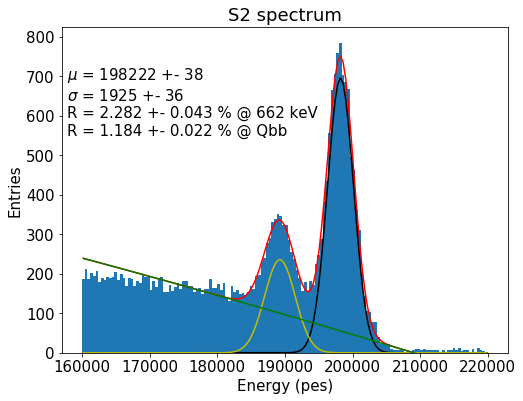

In [67]:
y, x, _ = \
hist(E_xyzcorr[full.R.values<100], 150, (160e3, 220e3))

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e5, 200e3, 1e3, 1e5, 190e3, 1e3, 1e2, -40, 1e-4
fitr = 170e3, 210e3

f = fitf.fit(fun, x, y, seed, fit_range=fitr, sigma=poisson_sigma(y))

assert not np.any(np.isclose(f.values, seed))

print("Resolution at 662  keV:", measurement_string(*resolution(f.values, f.errors, 662)[0]))
print("Resolution at 2458 keV:", measurement_string(*resolution(f.values, f.errors, 662)[1]))
print("Chi2                  :", f.chi2)

plt.plot(x, f.fn(x), "r-")
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")


plt.text(plt.xlim()[0] * 1.005, plt.ylim()[1]/1.5,
         gausstext(f.values, f.errors, 662))

plt.ylim(0)
labels("Energy (pes)", "Entries", "S2 spectrum")

In [68]:
print("# events in photopeak:", np.count_nonzero(coref.in_range(E_xyzcorr, 191e3, 202e3)))
print("# events in XR       :", np.count_nonzero(coref.in_range(E_xyzcorr,   8e3,  11e3)))

# events in photopeak: 26006
# events in XR       : 14793


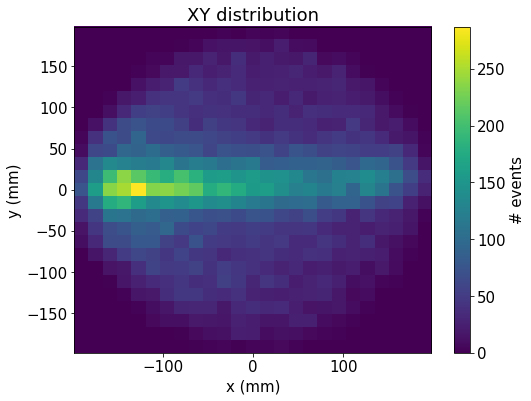

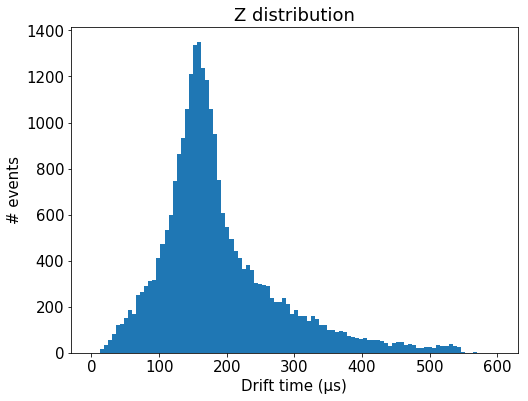

In [69]:
sel = coref.in_range(E_xyzcorr, 191e3, 202e3)

data = full[sel]
hist2d(data.X.values, data.Y.values, (nX//2, nY//2), (XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "XY distribution")

hist(data.Z.values, 100, (Zrange))
labels("Drift time (µs)", "# events", "Z distribution")

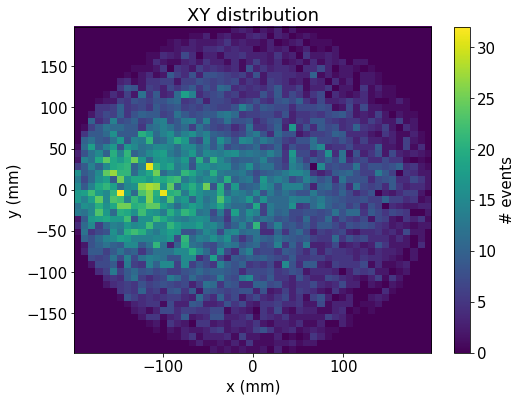

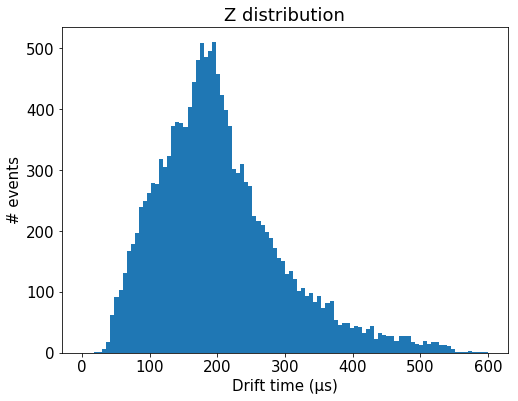

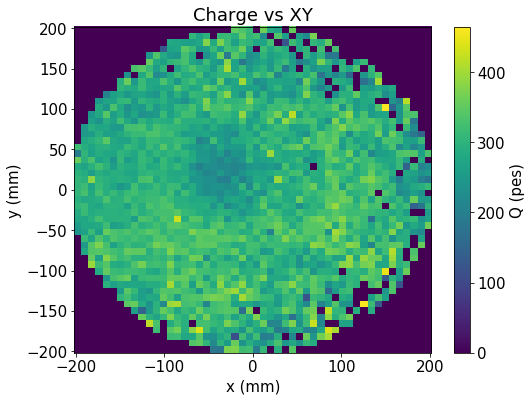

In [71]:
T   = full.time.values - full.time.values.min()
sel = coref.in_range(E_xyzcorr, 8e3, 11e3) &\
      coref.in_range(T, T - 12*3600, T.max()+1)

data = full[sel]
hist2d(data.X.values, data.Y.values, (nX, nY), (XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "XY distribution")

hist(data.Z.values, 100, (Zrange))
labels("Drift time (µs)", "# events", "Z distribution")

x, y, Q, u_Q = \
fitf.profileXY(data.X, data.Y, data.S2q, nX, nY, XYrange, XYrange)
_, cb = display_matrix(x, y, Q)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")

# Tracking charge

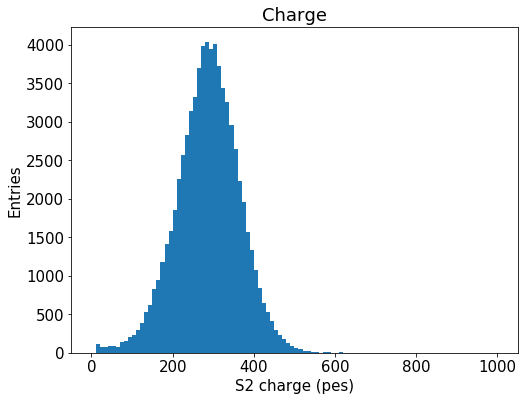

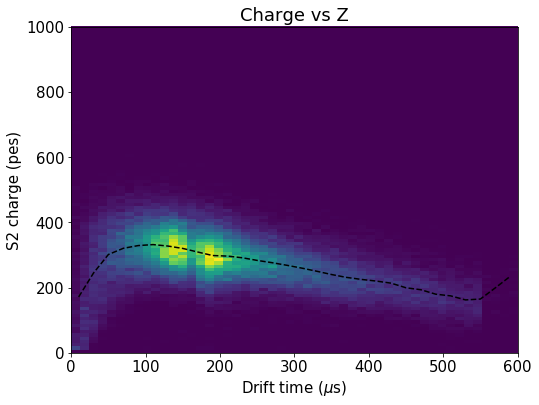

In [21]:
hist(Kr.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries", "Charge")
save("Q")

hist2d(Kr.Z, Kr.S2q, (50, 100), range=(Zrange, Qrange))
x, y, _ = fitf.profileX(Kr.Z, Kr.S2q, 30, xrange=Zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)", "Charge vs Z")
save("QvsZ")

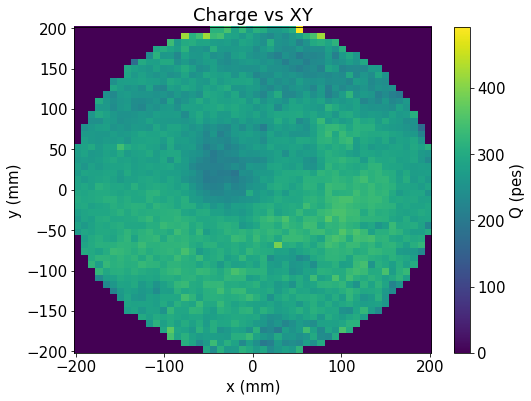

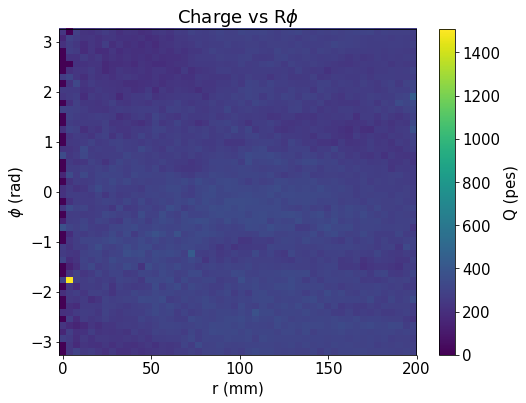

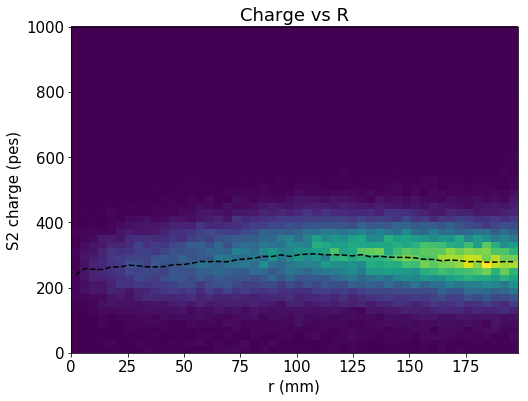

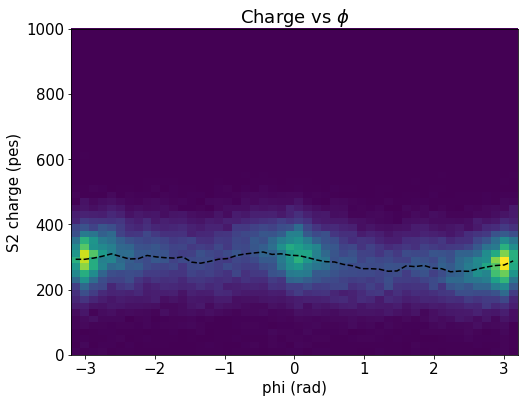

In [22]:
x, y, Q, u_Q = \
fitf.profileXY(Kr.X, Kr.Y, Kr.S2q, nX, nY, XYrange, XYrange)
_, cb = display_matrix(x, y, Q)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("QvsXY")

x, y, q, u_q = \
fitf.profileXY(Kr.R, Kr.Phi, Kr.S2q, nX, nY, Rrange, Prange)
_, cb = display_matrix(x, y, q)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)", "Charge vs R$\phi$")
save("QvsRPhi")

hist2d(Kr.R, Kr.S2q, (50, 50), (Rrange, Qrange))
x, y, _ = fitf.profileX(Kr.R, Kr.S2q, 50, xrange=Rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)", "Charge vs R")
save("QvsR")

hist2d(Kr.Phi, Kr.S2q, (50, 50), range=(Prange, Qrange))
x, y, _ = fitf.profileX(Kr.Phi, Kr.S2q, 50, xrange=Prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)", "Charge vs $\phi$")
save("QvsPhi")

# Energy vs position

Reference energy = 9139.681920990515 pes


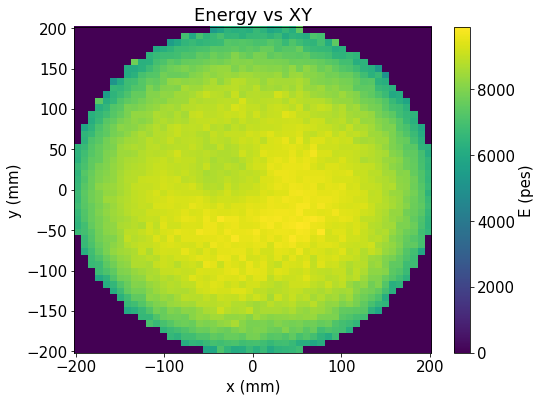

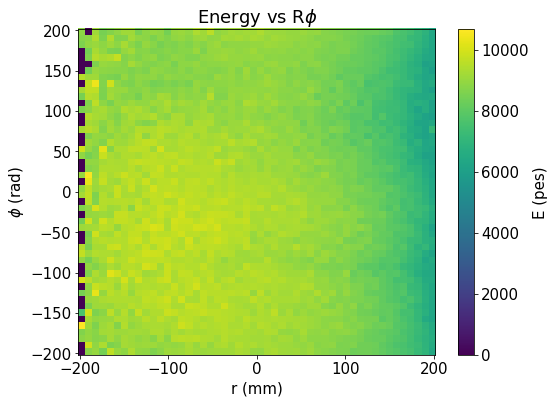

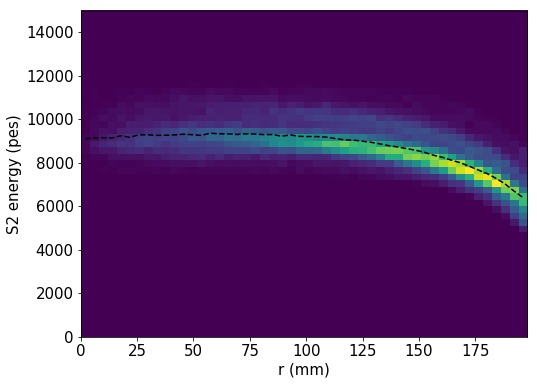

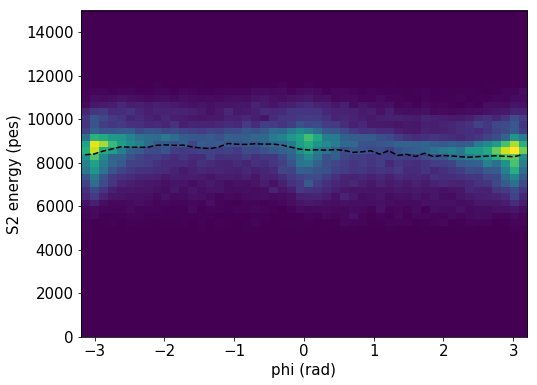

In [23]:
sel = sel_Kr = coref.in_range(Kr.Z.values, *Zrange_XY)

xc, yc, Ec, u_Ec = \
fitf.profileXY(Kr.X.values[sel], Kr.Y.values[sel], E_zcorr[sel], nX, nY, XYrange, XYrange)
_, cb = display_matrix(xc, yc, Ec)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)", "Energy vs XY")
save("EvsXY")

rc, pc, ec, u_ec = \
fitf.profileXY(Kr.R.values[sel], Kr.Phi.values[sel], E_zcorr[sel], nX, nY, Rrange, Prange)
_, cb = display_matrix(xc, yc, ec)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)", "Energy vs R$\phi$")
save("EvsRPhi")

hist2d(Kr.R.values[sel], E_zcorr[sel], (50, 50), range=(Rrange, Erange_zcorr))
x, y, _ = fitf.profileX(Kr.R.values[sel], E_zcorr[sel], 50, xrange=Rrange, yrange=Erange_zcorr)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(Kr.Phi.values[sel], E_zcorr[sel], (50, 50), range=(Prange, Erange_zcorr))
x, y, _ = fitf.profileX(Kr.Phi.values[sel], E_zcorr[sel], 50, xrange=Prange, yrange=Erange_zcorr)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

XYcorr2    = corrf.Correction((xc, yc), Ec, u_Ec, "index", index=(nX//2, nY//2))
print("Reference energy = {} pes".format(Ec[tuple(np.argwhere(XYcorr2._fs==1)[0])]))

# Correction maps

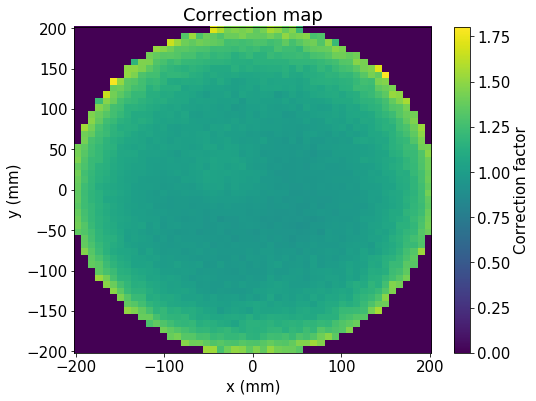

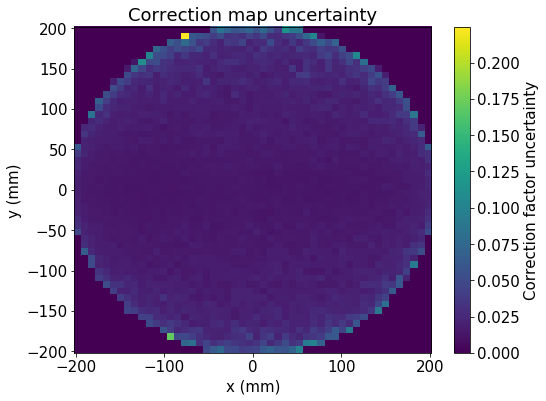

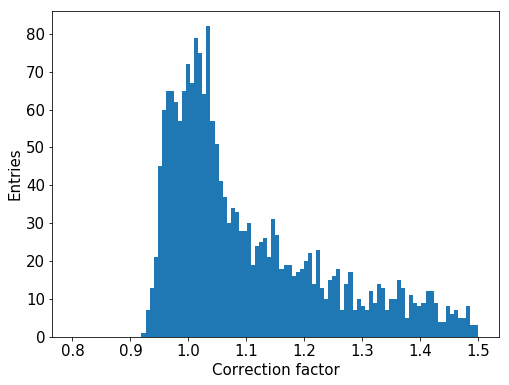

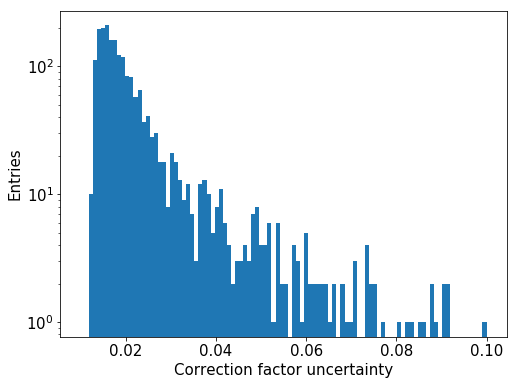

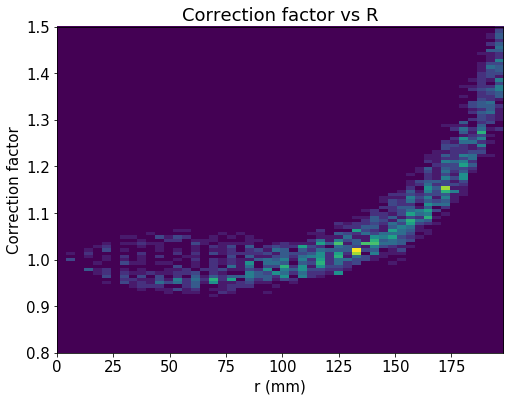

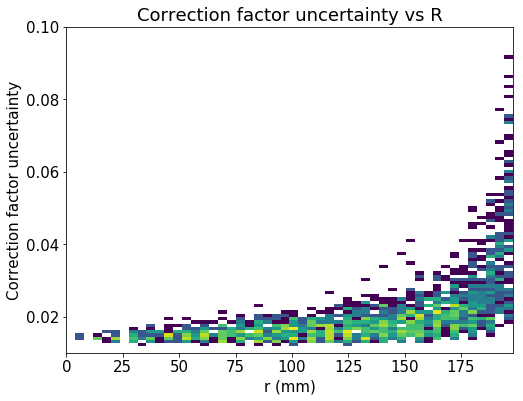

In [24]:
_r = (np.repeat(xc, yc.size)**2 +
      np.tile  (yc, xc.size)**2)**0.5
_f = XYcorr2._fs.flatten()
_u = XYcorr2._us.flatten()

_, cb = display_matrix(xc, yc, _f)
labels("x (mm)", "y (mm)", "Correction map")
cb.set_label("Correction factor")
save("CorrectionMap")

_, cb = display_matrix(xc, yc, _u)
labels("x (mm)", "y (mm)", "Correction map uncertainty")
cb.set_label("Correction factor uncertainty")
save("CorrectionMapUncertainty")

hist(_f, 100, Frange)
labels("Correction factor", "Entries")
save("CorrectionMapHist")

hist(_u[_u > 0], 100, Urange)
plt.yscale("log")
labels("Correction factor uncertainty", "Entries")
save("CorrectionMapUncertaintyHist")

hist2d(_r, _f, (nR, 100), (Rrange, Frange))
labels("r (mm)", "Correction factor", "Correction factor vs R")
save("CorrectionFactorVsR")

hist2d(_r, _u, (nR, 100), (Rrange, Urange), norm=LogNorm())
labels("r (mm)", "Correction factor uncertainty", "Correction factor uncertainty vs R")
save("CorrectionFactorUncertaintyVsR")

[ 7.63125318  0.99973037  0.01408593]


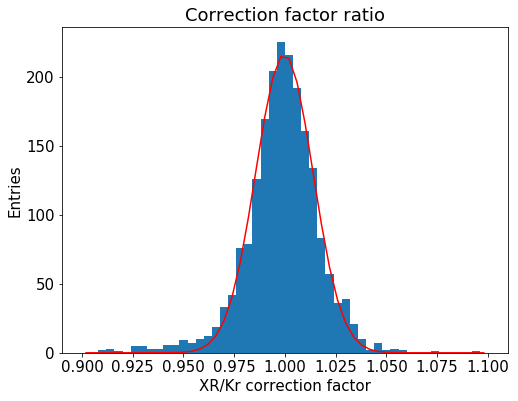

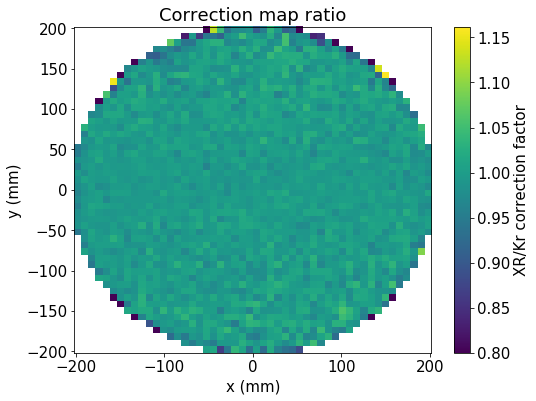

In [25]:
ratio = XYcorr2._fs / XYcorr._fs

y, x, _ = \
hist(ratio.flatten(), 50, (0.9, 1.1))
labels("XR/Kr correction factor", "Entries", "Correction factor ratio")

f = fitf.fit(fitf.gauss, x, y, (1e3, 1, 0.1))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)

_, cb = display_matrix(xc, yc, ratio, vmin=0.8)
labels("x (mm)", "y (mm)", "Correction map ratio")
cb.set_label("XR/Kr correction factor")
save("CorrectionMapRatio")

# Charge/Energy ratio

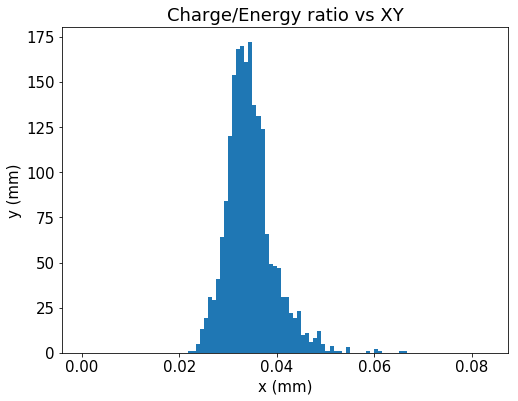

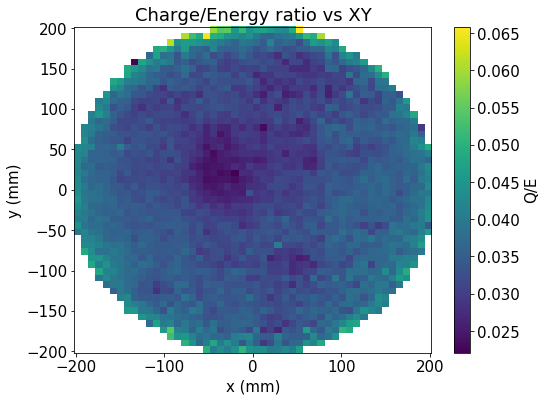

In [26]:
ratio = Q/Ec

hist(ratio.flatten(), 100, QErange)
cb.set_label("Q/E")
labels("x (mm)", "y (mm)", "Charge/Energy ratio vs XY")
save("QoverEvsXY")

_, cb = display_matrix(xc, yc, ratio)
cb.set_label("Q/E")
labels("x (mm)", "y (mm)", "Charge/Energy ratio vs XY")
save("QoverEvsXY")

# Correction by position with Kr map

[  3.01639360e+06   8.86407986e+03   2.90158232e+02   8.11349278e+05
   1.00527194e+04   3.25405056e+02   1.75091859e+02]


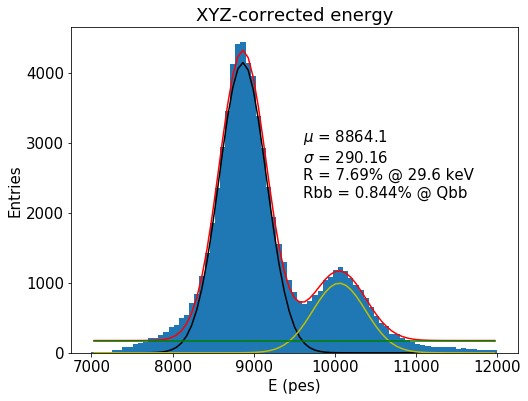

In [27]:
E_xyzcorr = E_zcorr * XYcorr(Kr.X.values, Kr.Y.values).value

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyzcorr, bins)

fun  = lambda x, *args: fitf.gauss(x, *args[ :3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e3, 9000, 400, 1e3, 10000, 400,  100
low  = 1e1, 8000, 200, 1e1,  9900, 200,    0
upp  = 1e8, 9500, 900, 1e8, 11000, 900, 5000
f    = fitf.fit(fun, x, y, seed, fit_range=(7500, 11500), bounds=(low, upp))
print(f.values)


plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")
plt.text(Erange_xycorr[1]*0.8, max(y)/2, gausstext(f.values, 29.6))

labels("E (pes)", "Entries", "XYZ-corrected energy")
save("EcorrZXY")

# Correction by position with XR map

[  3.07485784e+06   8.86104272e+03   3.08036462e+02   8.09108785e+05
   1.00284341e+04   3.27458081e+02   1.62914776e+02]


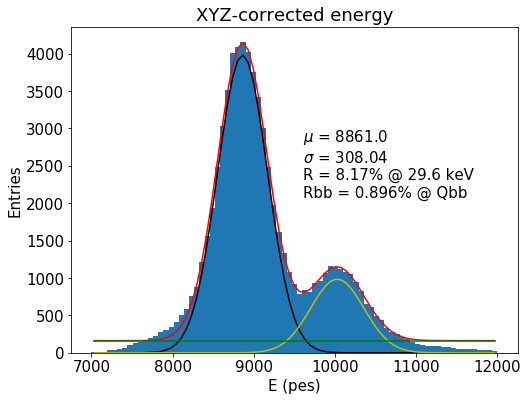

In [28]:
E_xyzcorr2 = E_zcorr * XYcorr2(Kr.X.values, Kr.Y.values).value

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyzcorr2, bins)

fun  = lambda x, *args: fitf.gauss(x, *args[ :3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e3, 9000, 400, 1e3, 10000, 400,  100
low  = 1e1, 8000, 200, 1e1,  9900, 200,    0
upp  = 1e8, 9500, 900, 1e8, 11000, 900, 5000
f    = fitf.fit(fun, x, y, seed, fit_range=(7500, 11500), bounds=(low, upp))
print(f.values)


plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")
plt.text(Erange_xycorr[1]*0.8, max(y)/2, gausstext(f.values, 29.6))

labels("E (pes)", "Entries", "XYZ-corrected energy")
save("EcorrZXY")

# Correction by time

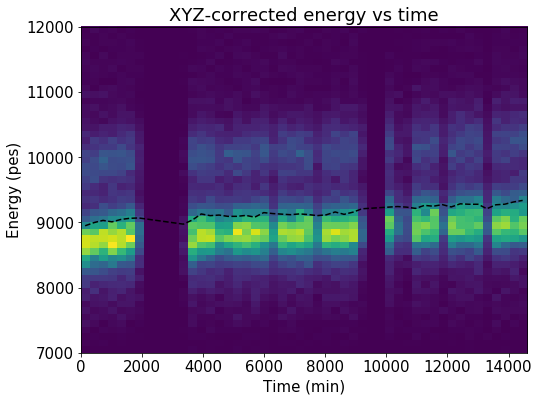

In [29]:
T      = (Kr.time.values - np.min(Kr.time.values))/60
Trange = 0, np.max(T)

hist2d(T, E_xyzcorr, (50, 50), range=(Trange, Erange_xycorr))

x, y, u_y = fitf.profileX(T, E_xyzcorr, 50, Trange, Erange_xycorr)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)", "XYZ-corrected energy vs time")
save("EcorrZXYvsT")

Tcorr = corrf.Correction((x,), y, u_y, "max")

[  3.01772335e+06   9.04848189e+03   2.81751040e+02   7.92003379e+05
   1.02684486e+04   3.09705529e+02   1.77679075e+02]


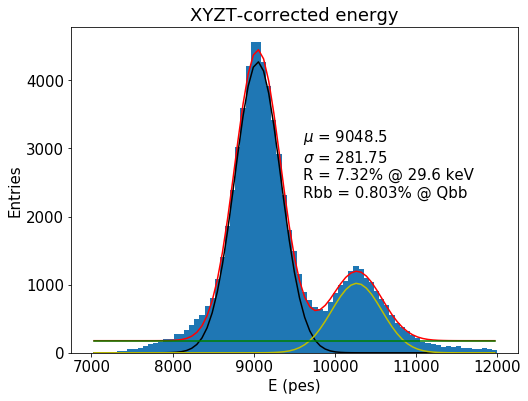

In [30]:
E_xyztcorr = E_xyzcorr * Tcorr(T).value

bins     = np.linspace(*Erange_xycorr, 80)
bin_size = np.diff(bins)[0]
y, x, _  = hist(E_xyztcorr, bins)

fun  = lambda x, *args: fitf.gauss(x, *args[ :3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e3, 9000, 400, 1e3, 10000, 400,  100
low  = 1e1, 8000, 200, 1e1,  9900, 200,    0
upp  = 1e8, 9500, 900, 1e8, 11000, 900, 5000
f    = fitf.fit(fun, x, y, seed, fit_range=(7500, 11500), bounds=(low, upp))
print(f.values)


plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")
plt.text(Erange_xycorr[1]*0.8, max(y)/2, gausstext(f.values, 29.6))

labels("E (pes)", "Entries", "XYZT-corrected energy")
save("EcorrZXYT")

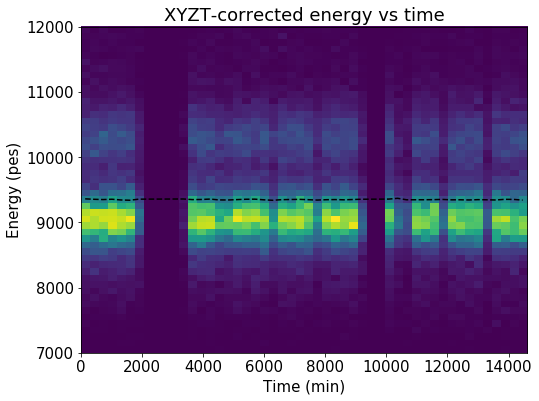

In [31]:
hist2d(T, E_xyztcorr, (50, 50), range=(Trange, Erange_xycorr))
x, y, _ = fitf.profileX(T, E_xyztcorr, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)", "XYZT-corrected energy vs time")
save("EcorrZXYTvsT")

In [32]:
Narange_zcorr   = 100e3, 200e3
Narange_xyzcorr = 120e3, 180e3
Zrange_Na       = 100, 200
Yrange_Na       = -30,  30
E_zcorr_full    = full.S2e.values * correction.value

In [33]:
full.R.values.size, E_zcorr_full.size, Rrange, Narange_zcorr

(444610, 444610, (0, 198), (100000.0, 200000.0))

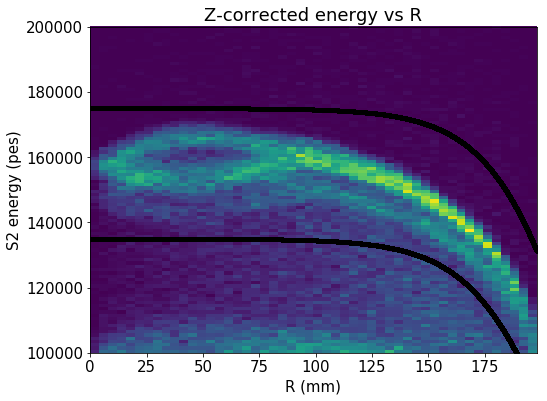

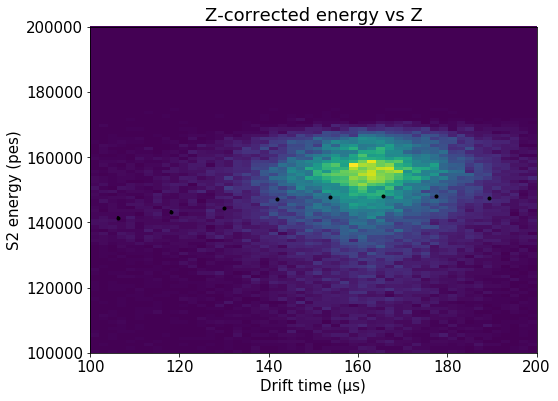

In [34]:
low_cut   = 135e3 *(1/(1 + np.exp((full.R.values-210)/20)))
high_cut  = 175e3 *(1/(1 + np.exp((full.R.values-220)/20)))

hist2d(full.R.values, E_zcorr_full , (50, 100), range=(Rrange, Narange_zcorr))
plt.plot(full.R.values,  low_cut, ".k")
plt.plot(full.R.values, high_cut, ".k")
labels("R (mm)", "S2 energy (pes)", "Z-corrected energy vs R")
sel_r = coref.in_range(E_zcorr_full, low_cut, high_cut)

hist2d(full.Z.values[sel_r], E_zcorr_full[sel_r] , (50, 100), range=(Zrange_Na, Narange_zcorr))
x, y, u_y = fitf.profileX(full.Z.values[sel_r], E_zcorr_full[sel_r], 50)
plt.errorbar(x, y, u_y, fmt="k.")
labels("Drift time (µs)", "S2 energy (pes)", "Z-corrected energy vs Z")

In [35]:
sel_y = coref.in_range(full.Y.values, *Yrange_Na)

In [36]:
Na      =         full[sel_r & sel_y]
E_zcorr = E_zcorr_full[sel_r & sel_y]

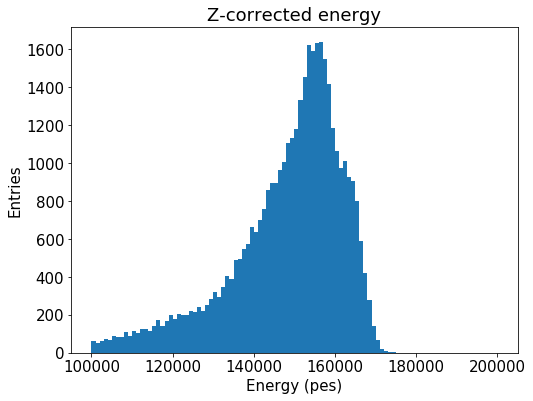

In [37]:
hist(E_zcorr, 100, Narange_zcorr)
labels("Energy (pes)", "Entries", "Z-corrected energy")

# Apply Kr map

10.0951234938
[  1.25405910e+07   1.60665519e+05   1.50146593e+03   4.40249242e+06
   1.51094732e+05   1.45879267e+03  -3.29971969e+04   4.35084973e-01
  -1.42086917e-06]
[  2.88275353e+05   3.12951335e+01   3.05289895e+01   2.35170203e+05
   6.24594514e+01   6.92207151e+01   4.84021593e+03   6.24646988e-02
   2.00556972e-07]
(Measurement(value=2.1961432447912359, uncertainty=0.044655765411785418), Measurement(value=1.0013367941410689, uncertainty=0.02036090363568405))
(Measurement(value=2.2688830590848958, uncertainty=0.047484540413725032), Measurement(value=1.0039893453733231, uncertainty=0.021012088945896203))


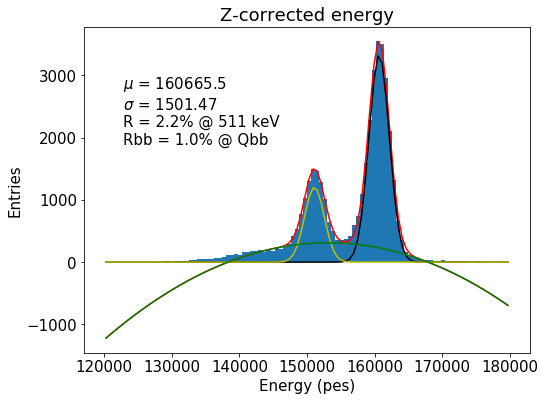

In [38]:
T      = (Na.time.values - np.min(Na.time.values))/60
E_xyzcorr = E_zcorr * XYcorr(Na.X.values, Na.Y.values).value * Tcorr(T).value
y, x, _ = \
hist(E_xyzcorr, 100, Narange_xyzcorr)
labels("Energy (pes)", "Entries", "Z-corrected energy")

fit_range = 142e3, 168e3
fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e5, 159e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2, +1e-8
f    = fitf.fit(fun, x, y, seed, fit_range=fit_range, sigma=poisson_sigma(y))
assert not np.any(np.isclose(f.values, seed))

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")

plt.text(plt.xlim()[0]*1.05, plt.ylim()[1]/2, gausstext(f.values, 511))
print(f.chi2)
print(f.values)
print(f.errors)
print(resolution(f.values[:3], f.errors, 511))
print(resolution(f.values[3:], f.errors, 511 - 29.7))

2.86670844135
[  1.24273528e+07   1.60238639e+05   1.99790697e+03   4.49637604e+06
   1.50788665e+05   1.95057656e+03  -2.97081619e+04   3.93467677e-01
  -1.28953629e-06]
[  3.47319585e+05   2.78023976e+01   3.89653617e+01   3.22453806e+05
   5.69410349e+01   9.01002212e+01   6.78265624e+03   8.77469677e-02
   2.82158549e-07]
(Measurement(value=2.9300557082844008, uncertainty=0.057147404838978295), Measurement(value=1.3359659469148801, uncertainty=0.026056496674643822))
(Measurement(value=3.0399200939973303, uncertainty=0.060729034526817285), Measurement(value=1.3451761530585744, uncertainty=0.02687282774473386))


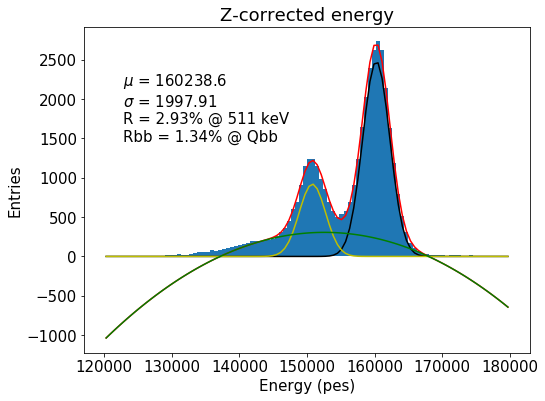

In [39]:
T      = (Na.time.values - np.min(Na.time.values))/60
E_xyzcorr = E_zcorr * XYcorr2(Na.X.values, Na.Y.values).value * Tcorr(T).value
y, x, _ = \
hist(E_xyzcorr, 100, Narange_xyzcorr)
labels("Energy (pes)", "Entries", "Z-corrected energy")

fit_range = 142e3, 168e3
fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e5, 159e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2, +1e-8
f    = fitf.fit(fun, x, y, seed, fit_range=fit_range, sigma=poisson_sigma(y))
assert not np.any(np.isclose(f.values, seed))

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")

plt.text(plt.xlim()[0]*1.05, plt.ylim()[1]/2, gausstext(f.values, 511))
print(f.chi2)
print(f.values)
print(f.errors)
print(resolution(f.values[:3], f.errors, 511))
print(resolution(f.values[3:], f.errors, 511 - 29.7))

# Na map

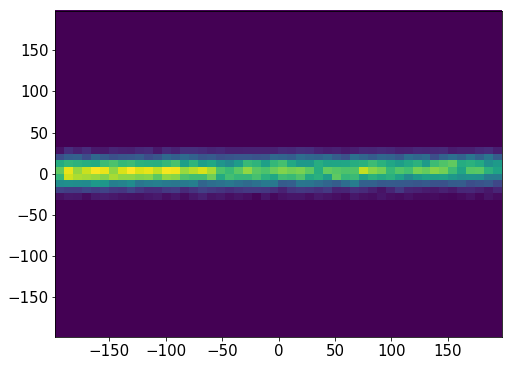

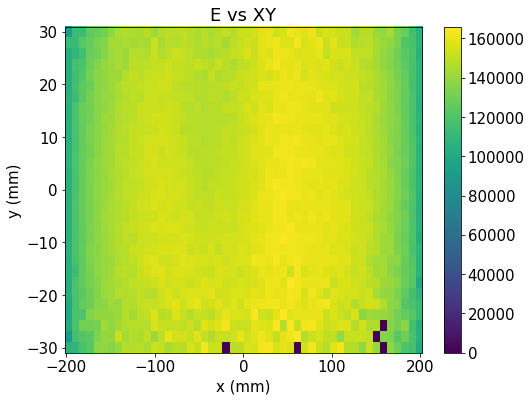

In [40]:
nx, ny = 50, 30
hist2d(Na.X.values, Na.Y.values, (50, 50), (XYrange, XYrange))
x, y, E, u_E = fitf.profileXY(Na.X.values, Na.Y.values, E_zcorr, nx, ny, XYrange, Yrange_Na)
display_matrix(x, y, E)
labels("x (mm)", "y (mm)", "E vs XY")


XYcorrNa = corrf.Correction((x, y), E, u_E, "index", index=(nx//2, ny//2))

7.04418643382
[  1.42038104e+07   1.61491374e+05   1.95870814e+03   5.41929311e+06
   1.52363619e+05   1.89736424e+03   9.78661541e+02  -5.45098852e-03]
[  2.41104946e+05   3.39867098e+01   3.00076099e+01   1.99744812e+05
   6.35263816e+01   6.58708268e+01   9.19125396e+01   5.27645599e-04]
(Measurement(value=2.8502848147998976, uncertainty=0.043670776156381139), Measurement(value=1.2995942161832927, uncertainty=0.019911795415803939))
(Measurement(value=2.9264242832850997, uncertainty=0.046287228596386308), Measurement(value=1.2949538270363838, uncertainty=0.020482273932784647))


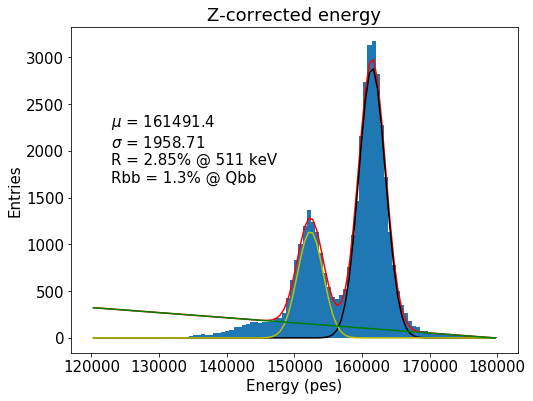

In [41]:
T      = (Na.time.values - np.min(Na.time.values))/60
E_xyzcorr = E_zcorr * XYcorrNa(Na.X.values, Na.Y.values).value * Tcorr(T).value
y, x, _ = \
hist(E_xyzcorr, 100, Narange_xyzcorr)
labels("Energy (pes)", "Entries", "Z-corrected energy")

fit_range = 145e3, 178e3
fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed = 1e5, 159e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2
f    = fitf.fit(fun, x, y, seed, fit_range=fit_range, sigma=poisson_sigma(y))
assert not np.any(np.isclose(f.values, seed))

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")

plt.text(plt.xlim()[0]*1.05, plt.ylim()[1]/2, gausstext(f.values, 511))
print(f.chi2)
print(f.values)
print(f.errors)
print(resolution(f.values[:3], f.errors, 511))
print(resolution(f.values[3:], f.errors, 511 - 29.7))

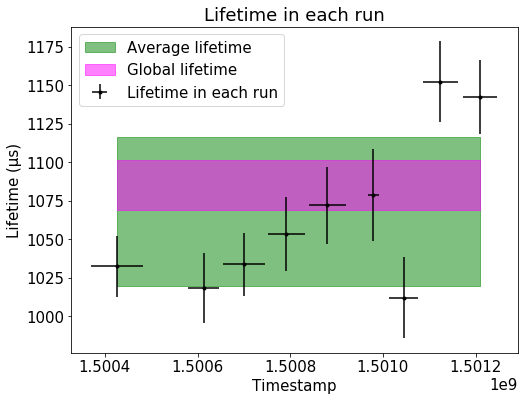

In [42]:
times       = []
u_times     = []
lifetimes   = []
u_lifetimes = []
for run_number in run_numbers:
    _fid      = dstio.load_dst(inputfilename.format(run_number), "DST", "Events")
    _fid      = _fid[_fid.R < 100]

    low_cut   =  8000 * np.exp(-0.0011*_fid.Z.values)
    high_cut  = 11000 * np.exp(-0.0008*_fid.Z.values)
    sel       = coref.in_range(_fid.S2e.values, low_cut, high_cut) # remove low and high E background

    x, y, u_y = fitf.profileX(_fid.Z[sel], _fid.S2e[sel], 100, xrange=Zrange, yrange=Erange_raw)

    #plt.figure()
    #plt.plot(x, y, profOpt)
    #plt.plot(_fid.Z.values,  low_cut, "k.")
    #plt.plot(_fid.Z.values, high_cut, "k.")

    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    sel  = u_y/y > 1e-3
    f    = fitf.fit(fitf.expo, x[sel], y[sel], seed, fit_range=Zrange_LT, sigma=u_y[sel])
    assert not np.any(np.isclose(f.values, seed))
    
    #plt.plot(x, f.fn(x), fitOpt)
    #print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
    #print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
    #print("Chi2          = {:.2f}          ".format(f.chi2))

    #labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
    times      .append(_fid.time.mean())
    u_times    .append((_fid.time.max() - _fid.time.min())/2)
    lifetimes  .append(-f.values[1])
    u_lifetimes.append( f.errors[1])

global_lifetime   = 1085
u_global_lifetime = 16.4

plt.errorbar(times, lifetimes, u_lifetimes, u_times, ".k", label="Lifetime in each run")
average   = np.average(lifetimes, weights=u_lifetimes)
u_average = np.average((lifetimes-average)**2, weights=u_lifetimes)**0.5
plt.fill_between(times, average - u_average , average + u_average, alpha=0.5, color="green", label="Average lifetime")
plt.fill_between(times, global_lifetime - u_global_lifetime, global_lifetime + u_global_lifetime, alpha=0.5, color="magenta", label="Global lifetime")
plt.legend()
labels("Timestamp", "Lifetime (µs)", "Lifetime in each run")

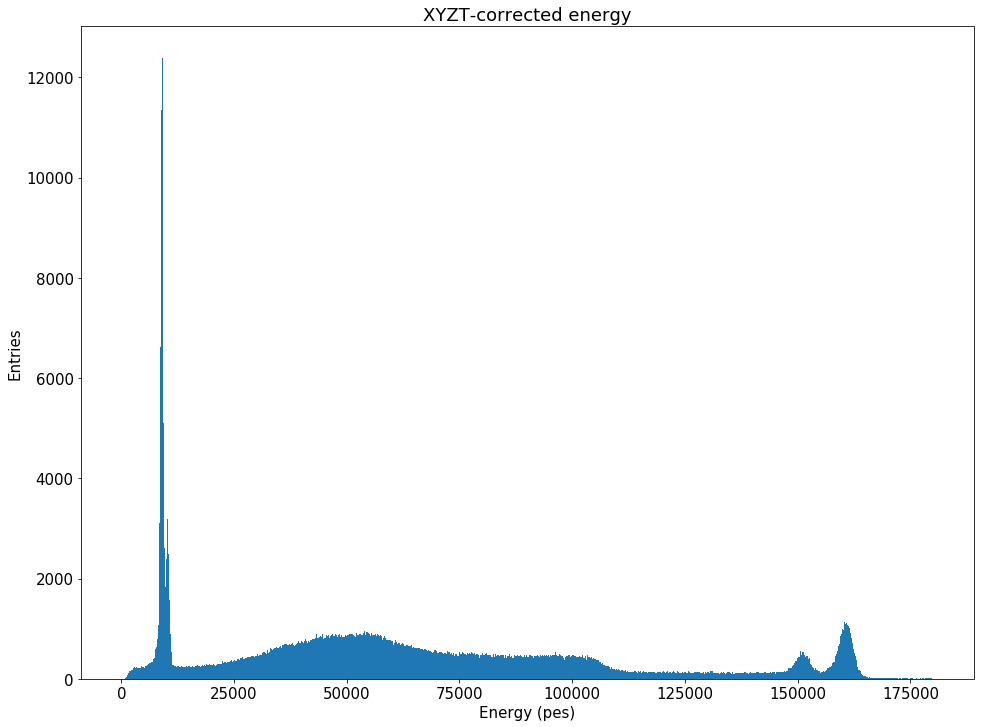

In [43]:
T              = (full.time.values - np.min(full.time.values))/60
E_xyzcorr_full = E_zcorr_full * XYcorr(full.X.values, full.Y.values).value * Tcorr(T).value

plt.figure(figsize=(16,12))
y, x, _ = \
hist(E_xyzcorr_full, 1000, (0, Narange_xyzcorr[1]), new_figure=False)
labels("Energy (pes)", "Entries", "XYZT-corrected energy")

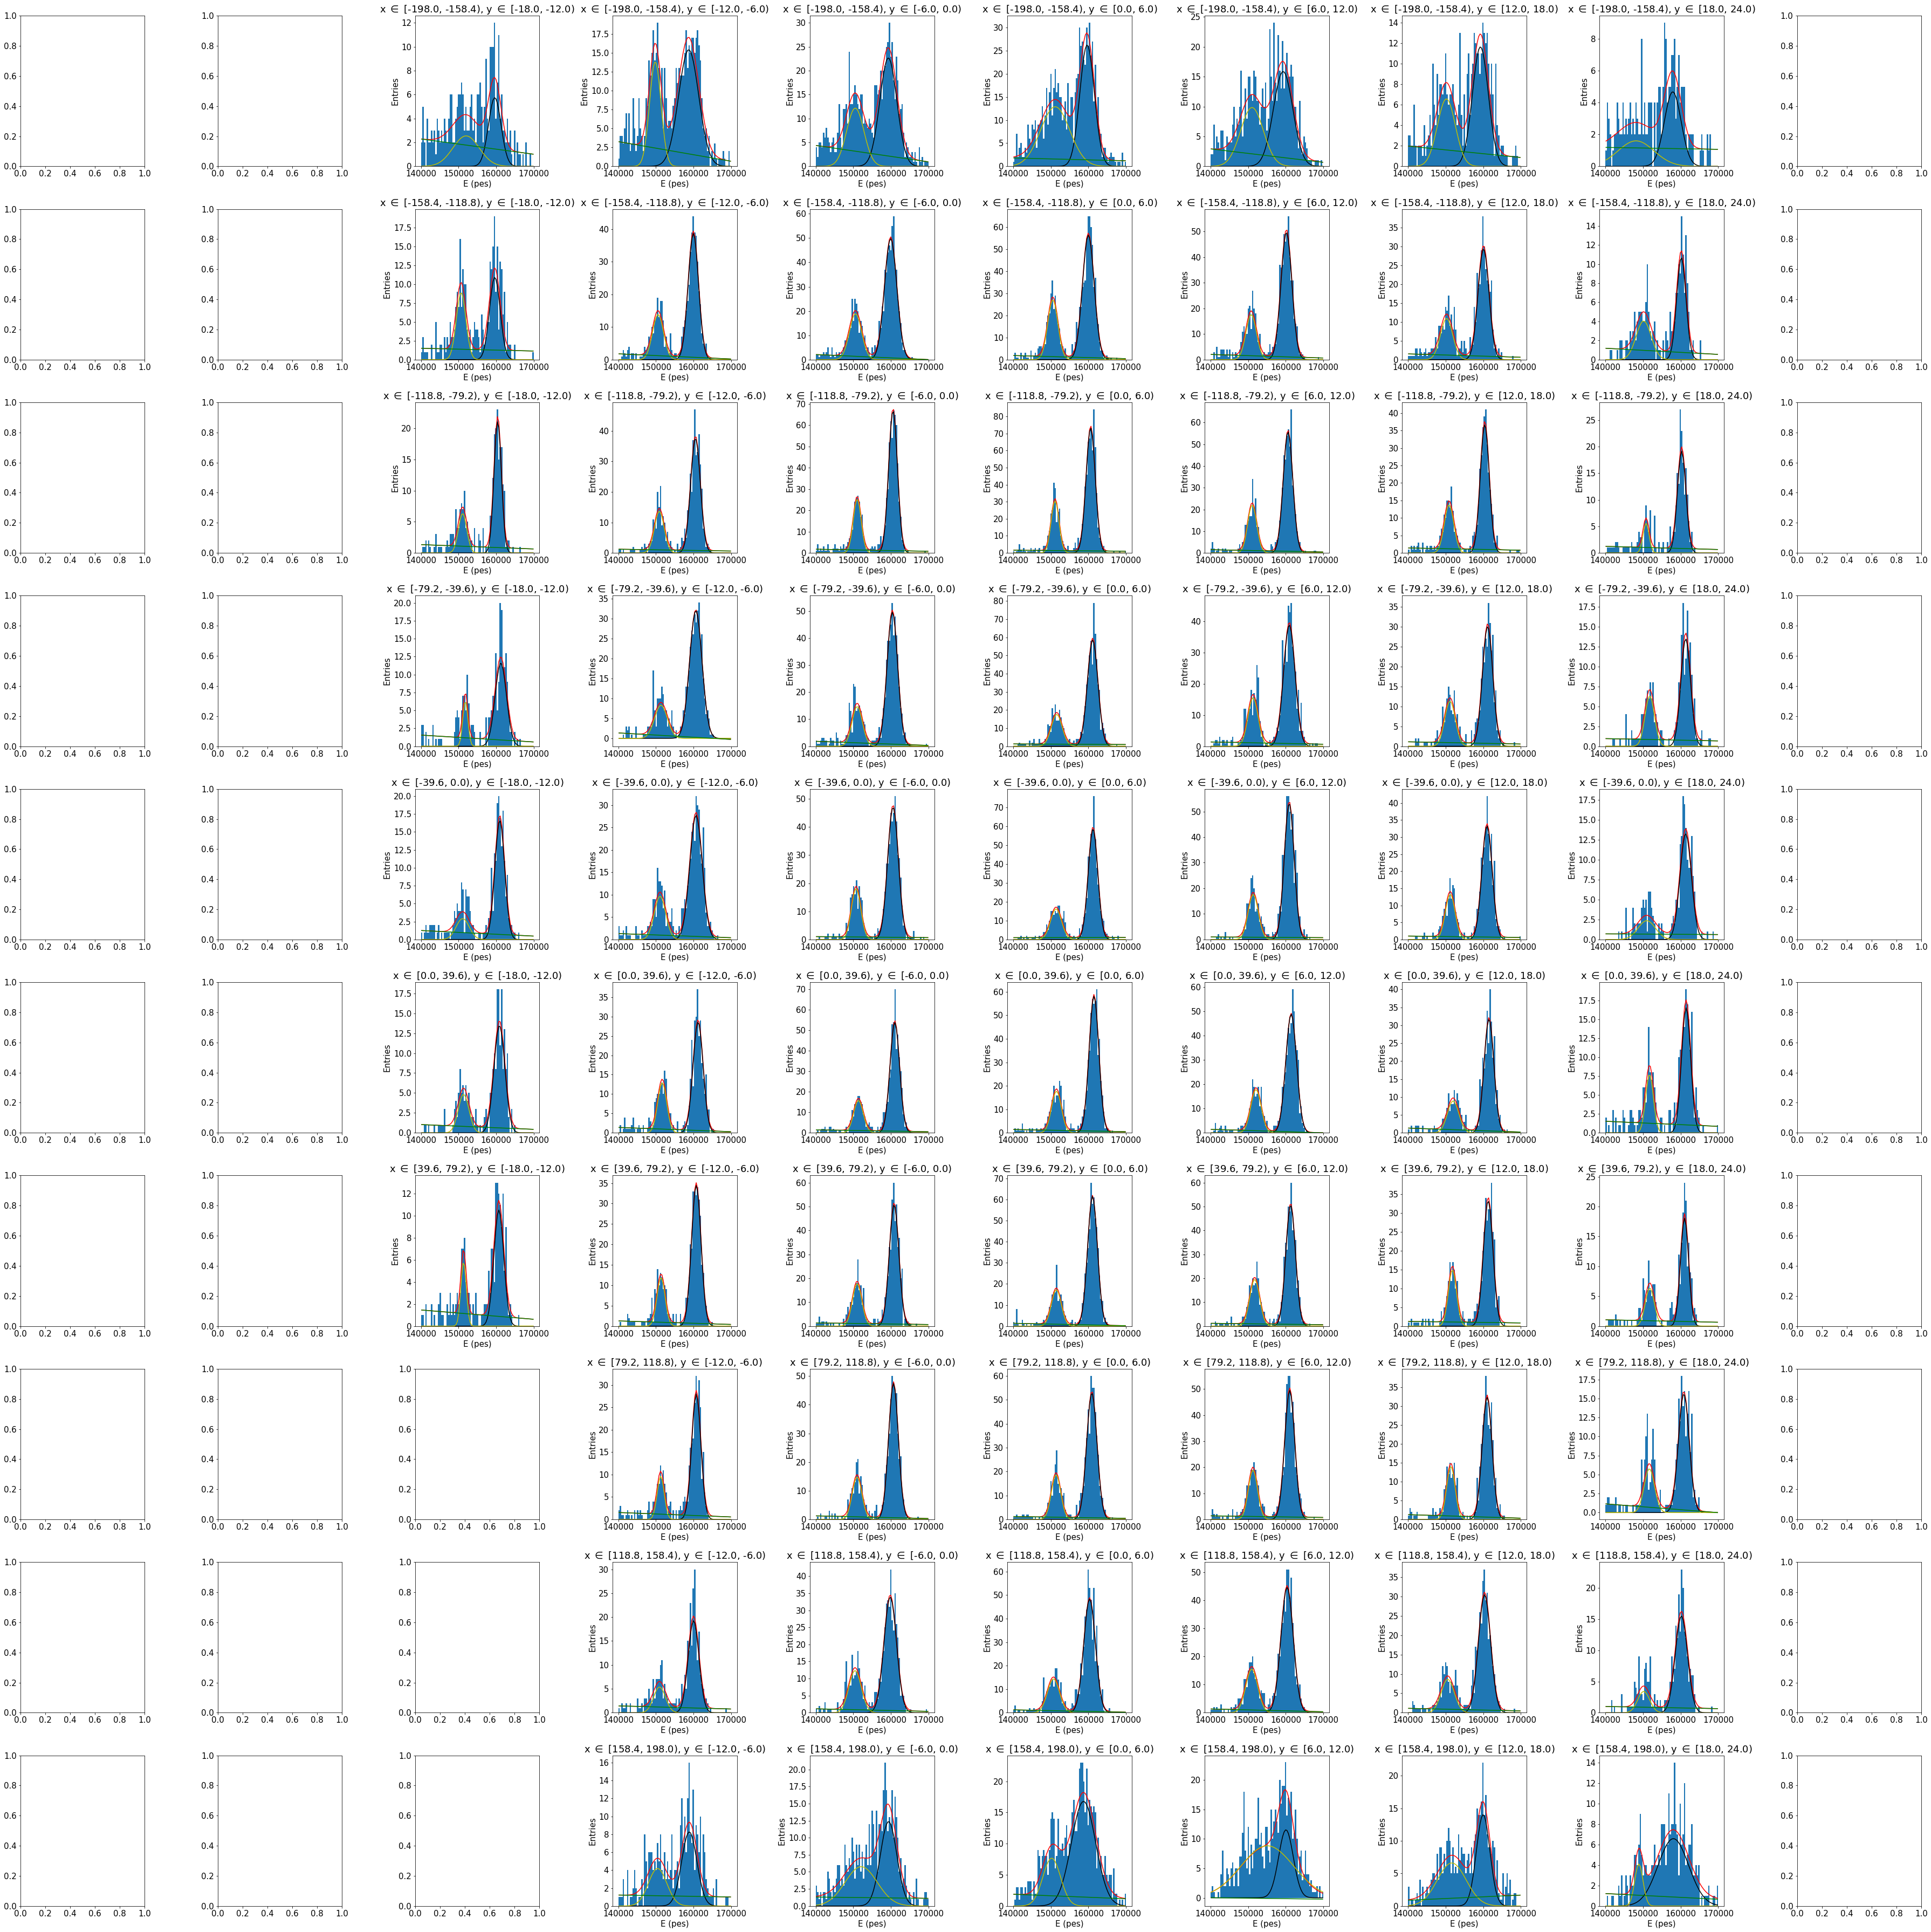

In [44]:
nx, ny = 10, 10
xbins  = np.linspace(*XYrange, nx+1)
ybins  = np.linspace(* Yrange_Na, ny+1)
Ebins  = np.linspace(140e3, 170e3, 80)

fit_range = 145e3, 178e3
fun       = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed      = 1e5, 159e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2#, +1e-8

T          = (Na.time.values - np.min(Na.time.values))/60
E_xyzcorr  = E_zcorr * XYcorr(Na.X.values, Na.Y.values).value * Tcorr(T).value
R_values   = np.zeros((nx, ny))
u_R_values = np.zeros_like(R_values) 

plt.figure(figsize=(5*nx, 5*ny))
for i in range(nx):
    for j in range(ny):
        plt.subplot(nx, ny, i*ny + j + 1)

        sel = coref.in_range(Na.X.values, *xbins[i:i+2]) &\
              coref.in_range(Na.Y.values, *ybins[j:j+2])
        if np.count_nonzero(sel) < 200:
            continue
        
        E       = E_xyzcorr[sel]
        y, x, _ = hist(E, Ebins, new_figure=False)
        title   = "x $\in$ [{:.1f}, {:.1f}), y $\in$ [{:.1f}, {:.1f})".format(*xbins[i:i+2],
                                                                              *ybins[j:j+2])
        labels("E (pes)", "Entries", title)

        f    = fitf.fit(fun, x, y, seed, sigma=poisson_sigma(y), maxfev=10000)
        plt.plot(x, f.fn(x), fitOpt)
        plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
        plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
        plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")        
        
        res, res_bb = resolution(f.values, f.errors, 511)
        R_values  [i, j] = res_bb.value
        u_R_values[i, j] = res_bb.uncertainty
plt.tight_layout()

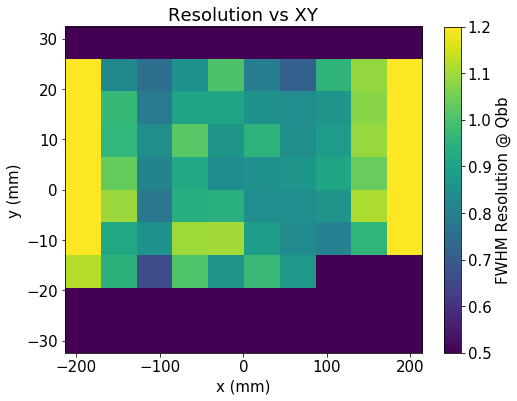

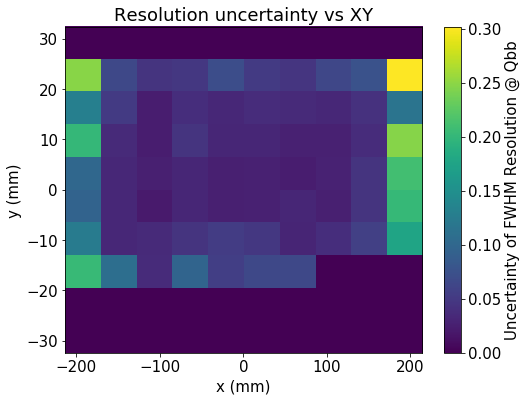

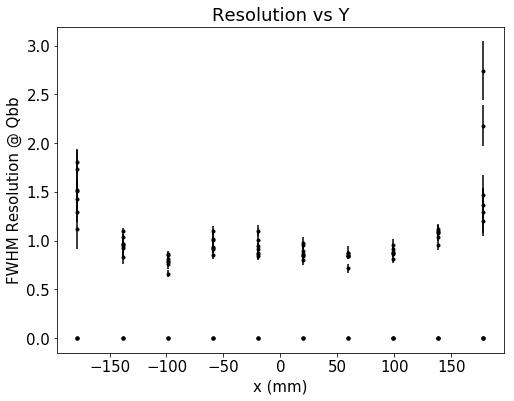

In [45]:
_x = shift_to_bin_centers(xbins)
_y = shift_to_bin_centers(ybins)

_, cb = display_matrix(_x, _y,   R_values, vmin=0.5, vmax=1.2)
cb.set_label("FWHM Resolution @ Qbb")
labels("x (mm)", "y (mm)", "Resolution vs XY")

_, cb = display_matrix(_x, _y, u_R_values)
cb.set_label("Uncertainty of FWHM Resolution @ Qbb")
labels("x (mm)", "y (mm)", "Resolution uncertainty vs XY")

plt.figure()
plt.errorbar(np.repeat(_x, ny), R_values.flatten(), u_R_values.flatten(), fmt="k.")
labels("x (mm)", "FWHM Resolution @ Qbb", "Resolution vs Y")

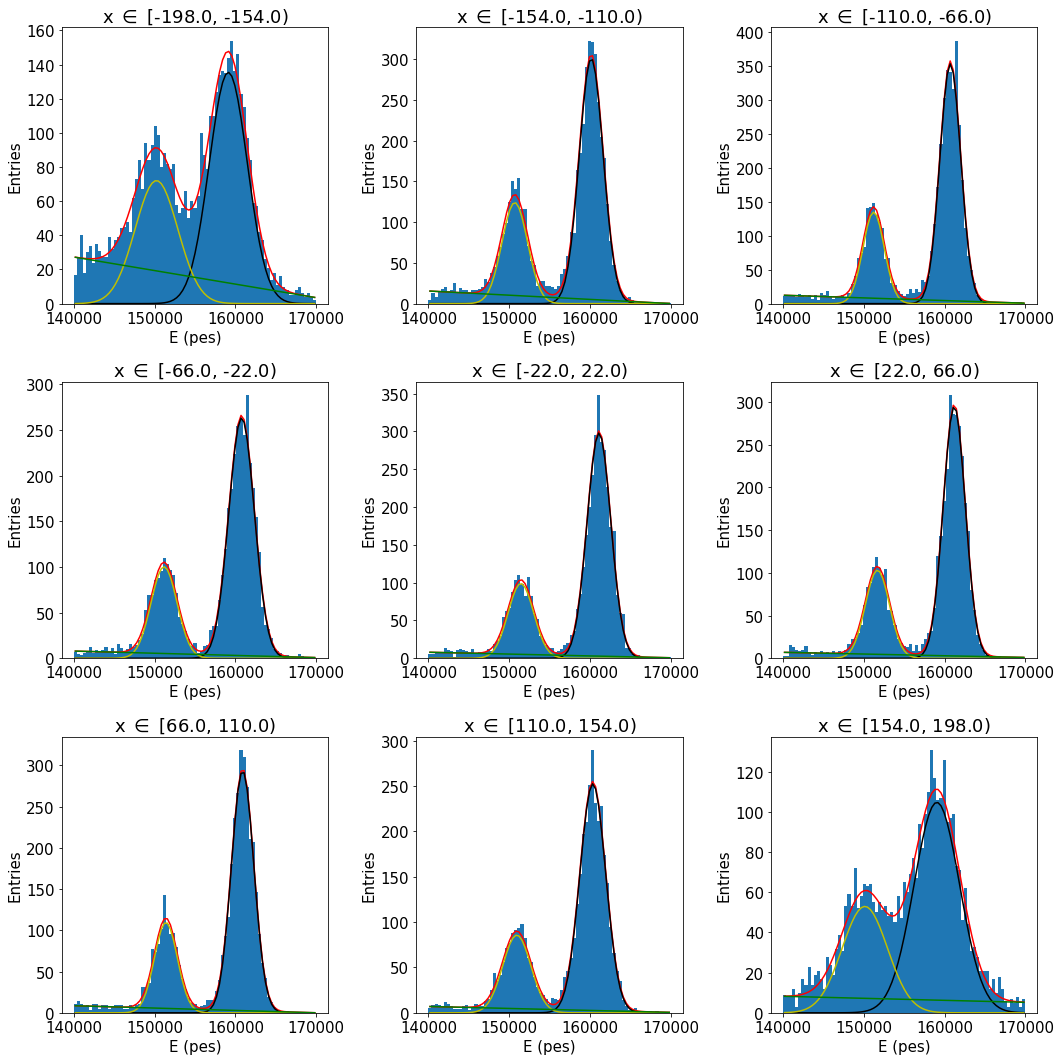

In [57]:
nx     = 9
xbins  = np.linspace(*XYrange, nx+1)
Ebins  = np.linspace(140e3, 170e3, 80)

fit_range = 140e3, 170e3
fun       = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed      = 1e5, 160e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2#, +1e-8
lower     =   0, 156e3, 1e2,   0, 145e3, 1e2, 1e1, -1e-1
upper     = 1e9, 165e3, 1e4, 1e9, 154e3, 1e4, 1e8, +1e-8

T          = (Na.time.values - np.min(Na.time.values))/60
E_xyzcorr  = E_zcorr * XYcorr(Na.X.values, Na.Y.values).value * Tcorr(T).value
R_values   = np.zeros(nx)
u_R_values = np.zeros_like(R_values) 

plt.figure(figsize=(5*nx**0.5, 5*nx**0.5))
for i in range(nx):
    plt.subplot(nx//int(nx**0.5), nx//int(nx**0.5), i + 1)

    sel = coref.in_range(Na.X.values, *xbins[i:i+2])
    if np.count_nonzero(sel) < 200:
        continue

    E       = E_xyzcorr[sel]
    y, x, _ = hist(E, Ebins, new_figure=False)
    title   = "x $\in$ [{:.1f}, {:.1f})".format(*xbins[i:i+2])
    labels("E (pes)", "Entries", title)
#    continue
    f    = fitf.fit(fun, x, y, seed, sigma=poisson_sigma(y), bounds=(lower, upper))
    plt.plot(x, f.fn(x), fitOpt)
    plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
    plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
    plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")        

    res, res_bb   = resolution(f.values, f.errors, 511)
    R_values  [i] = res_bb.value
    u_R_values[i] = res_bb.uncertainty
plt.tight_layout()

[ 1.5896445   0.9897145   0.86271288  1.05586708  0.97649839  0.90924822
  0.92467544  1.06949034  1.9079772 ]


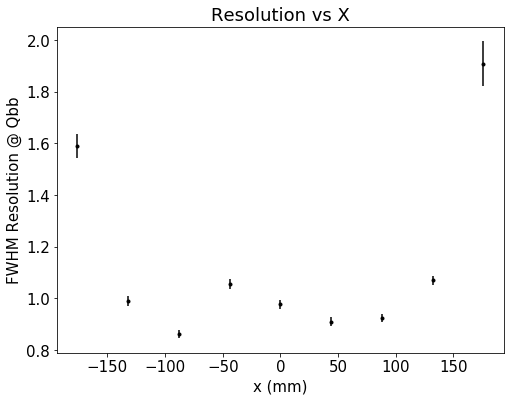

In [59]:
_x = shift_to_bin_centers(xbins)
print(R_values)
plt.errorbar(_x, R_values, u_R_values, fmt="k.")
#plt.ylim(0.5, 1.25)
labels("x (mm)", "FWHM Resolution @ Qbb", "Resolution vs X")

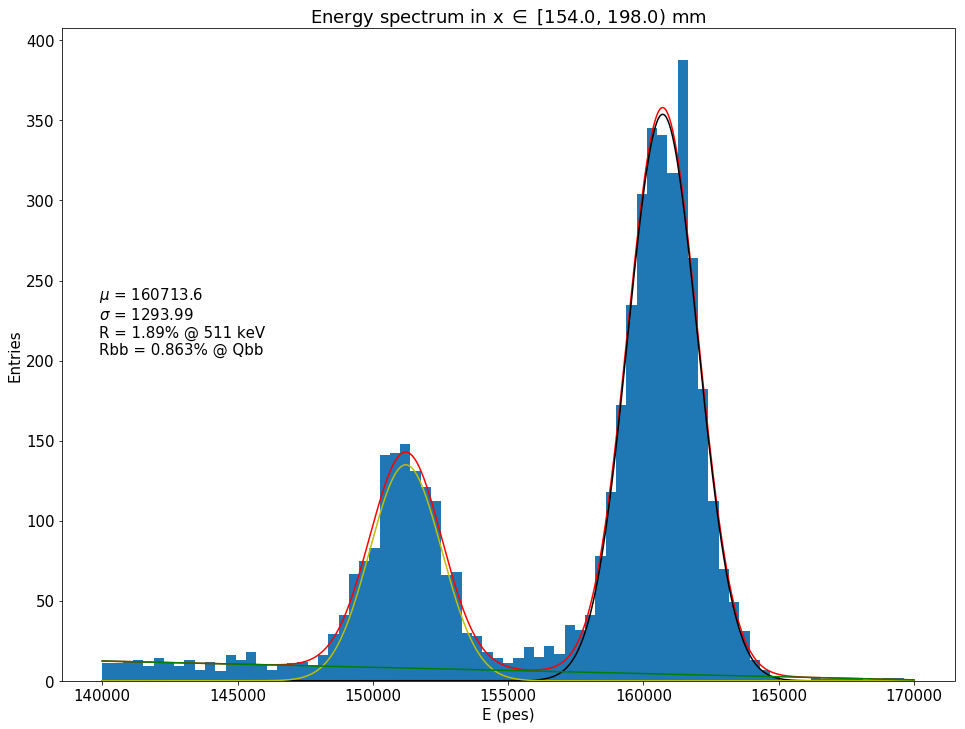

In [77]:
fit_range = 140e3, 170e3
fun       = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed      = 1e5, 160e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2
lower     =   0, 156e3, 1e2,   0, 145e3, 1e2, 1e1, -1e-1
upper     = 1e9, 165e3, 1e4, 1e9, 154e3, 1e4, 1e8, +1e-8

plt.figure(figsize=(16,12))
y, x, _ = hist(E_xyzcorr[coref.in_range(Na.X.values, *xbins[2:4])], Ebins, new_figure=False)

f = fitf.fit(fun, x, y, seed, sigma=poisson_sigma(y), bounds=(lower, upper))
x = np.linspace(*fit_range, 1000)
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "k-")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-")

plt.text(plt.xlim()[0] * 1.01, plt.ylim()[1]/2, gausstext(f.values, 511))

labels("E (pes)", "Entries", "Energy spectrum in {} mm".format(title))

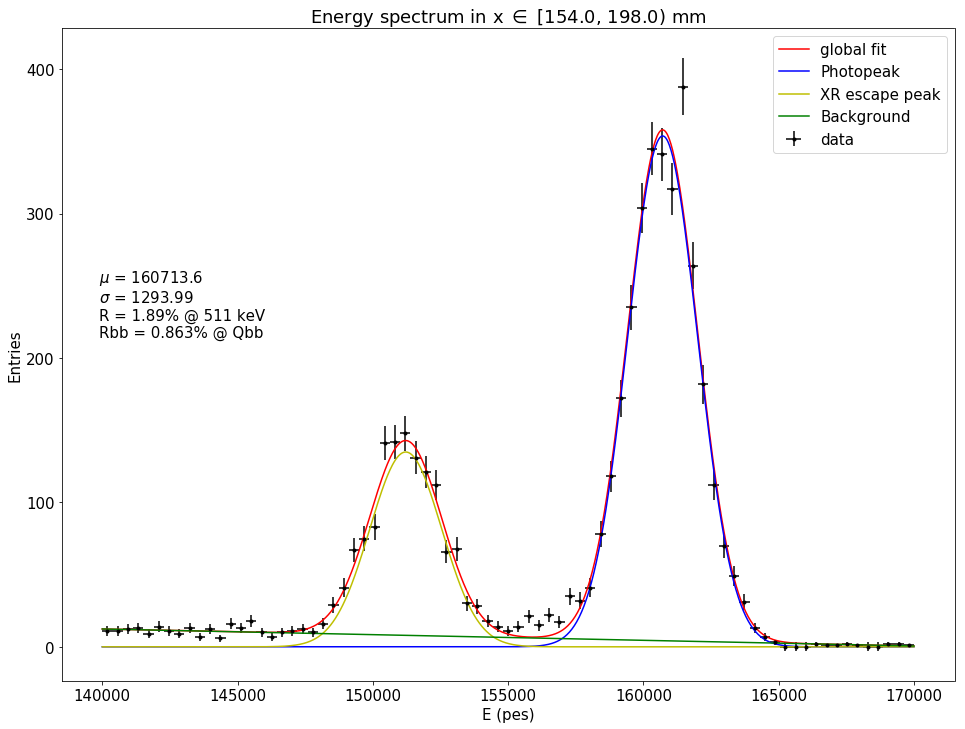

In [78]:
fit_range = 140e3, 170e3
fun       = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.polynom(x, *args[6:])
seed      = 1e5, 160e3, 1e3, 1e4, 150e3, 1e3, 1e6, -1e-2
lower     =   0, 156e3, 1e2,   0, 145e3, 1e2, 1e1, -1e-1
upper     = 1e9, 165e3, 1e4, 1e9, 154e3, 1e4, 1e8, +1e-8

plt.figure(figsize=(16,12))
#y, x, _ = hist(E_xyzcorr[coref.in_range(Na.X.values, *xbins[2:4])], Ebins, new_figure=False)
y, x = np.histogram(E_xyzcorr[coref.in_range(Na.X.values, *xbins[2:4])], Ebins)
u_y  = poisson_sigma(y)
x    = shift_to_bin_centers(x)

plt.errorbar(x, y, u_y, np.diff(Ebins)*0.5, "k.", label="data")
f = fitf.fit(fun, x, y, seed, sigma=poisson_sigma(y), bounds=(lower, upper))
x = np.linspace(*fit_range, 1000)
plt.plot(x, f   .fn     (x                ), "r-", label="global fit")
plt.plot(x, fitf.gauss  (x, *f.values[ :3]), "b-", label="Photopeak")
plt.plot(x, fitf.gauss  (x, *f.values[3:6]), "y-", label="XR escape peak")
plt.plot(x, fitf.polynom(x, *f.values[6: ]), "g-", label="Background")

plt.text(plt.xlim()[0] * 1.01, plt.ylim()[1]/2, gausstext(f.values, 511))
plt.legend()
labels("E (pes)", "Entries", "Energy spectrum in {} mm".format(title))